***
### Name: Ofosu Osei
### NetID: oo46

### Partner:

### Name: Mai Nguyen
### NetID: mvn8
***

# Merging Data to Understand the Relationship between Drug Legalization and Violent Crime



In recent years, many US states have decided to legalize the use of marijuana. 

When these ideas were first proposed, there were many theories about the relationship between crime and the "War on Drugs" (the term given to US efforts to arrest drug users and dealers over the past several decades). 

In this exercise, we're going to test a few of those theories using drug arrest data from the state of California. 

Though California has passed a number of laws lessening penalities for marijuana possession over the years, arguably the biggest changes were in  2010, when the state changed the penalty for possessing a small amount of marijuana from a criminal crime to a "civil" penality (meaning those found guilty only had to pay a fine, not go to jail), though possessing, selling, or producing larger quantities remained illegal. Then in 2016, the state fully legalized marijuana for recreational use, not only making possession of small amounts legal, but also creating a regulatory system for producing marijuana for sale. 

Proponents of drug legalization have long argued that the war on drugs contributes to violent crime by creating an opportunity for drug dealers and organized crime to sell and distribute drugs, a business which tends to generate violence when gangs battle over territory. According to this theory, with drug legalization, we should see violent crime decrease after legalization in places where drug arrests had previously been common. 

**To be clear,** this is far from the only argument for drug legalization! It is simply the argument we are well positioned to analyze today. 


## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/html/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_merging.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex6_validate_keyword",
    "ex10_merged_successfully",
    "ex16_num_obs",
    "ex17_drug_change",
    "ex18_violent_change",
    "ex21_diffindiff",
    "ex23_diffindiff_proportionate",
}
```


### Submission Limits

Please remember that you are **only allowed three submissions to the autograder.** Your last submission (if you submit 3 or fewer times), or your third submission (if you submit more than 3 times) will determine your grade Submissions that error out will **not** count against this total.

## Pre-Legalization Analysis

### Exercise 1
We will begin by examining [county-level data on arrests from California in 2009](https://github.com/nickeubank/practicaldatascience/tree/master/Example_Data/ca). This data is derived directly from data hosted by the [Office of the California State Attorney General](https://openjustice.doj.ca.gov/data), but please follow the github link above and download and import the file `ca_arrests_2009.csv` (don't try and get it directly from the State Attorney General's office). 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("mode.copy_on_write", True)
results = {}
ca_arrests_2009 = pd.read_csv(
    "https://github.com/nickeubank/practicaldatascience/raw/master/Example_Data/ca/ca_arrests_2009.csv"
)
ca_arrests_2009.sample(10)

,Unnamed: 0,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL
12,1694,Imperial County,599,779,730,28,449,2585,6739,69
22,1704,Mendocino County,415,296,551,17,364,1643,3654,10
37,1719,San Francisco County,3629,2792,6867,51,3339,16678,14782,9
43,1725,Santa Cruz County,753,789,872,43,744,3201,10455,115
20,1702,Marin County,500,532,454,29,276,1791,5795,178
44,1726,Shasta County,464,505,434,36,505,1944,7829,422
5,1687,Colusa County,58,50,28,7,132,275,917,0
27,1709,Napa County,367,400,325,24,392,1508,3471,60
32,1714,Riverside County,5825,7082,5881,479,4832,24099,40087,2235
47,1729,Solano County,1599,1326,1422,81,1027,5455,10682,191


### Exercise 2
Use your data exploration skills to get a feel for this data. If you need to, you can find the [original codebook here](https://github.com/nickeubank/practicaldatascience/blob/master/Example_Data/ca/arrests_codebook.pdf) (This data is a version of that data, but collapsed to one observation per county.)

In [3]:
ca_arrests_2009 = ca_arrests_2009.drop(columns=["Unnamed: 0"])
# get the data types of each column
for c in ca_arrests_2009.columns:
    print(c, ca_arrests_2009[c].dtype)

COUNTY object
VIOLENT int64
PROPERTY int64
F_DRUGOFF int64
F_SEXOFF int64
F_ALLOTHER int64
F_TOTAL int64
M_TOTAL int64
S_TOTAL int64


In [4]:
# find the columns with missing values
ca_arrests_2009.isnull().sum()

COUNTY        0
VIOLENT       0
PROPERTY      0
F_DRUGOFF     0
F_SEXOFF      0
F_ALLOTHER    0
F_TOTAL       0
M_TOTAL       0
S_TOTAL       0
dtype: int64

In [5]:
# Get number of unique values in each column
print("Number of unique values in each column:")
for c in ca_arrests_2009.columns:
    print(c, ca_arrests_2009[c].nunique())
# Get total number of values in the dataset
print()
print("Number of values in dataset:", ca_arrests_2009.shape)

Number of unique values in each column:
COUNTY 58
VIOLENT 56
PROPERTY 56
F_DRUGOFF 57
F_SEXOFF 46
F_ALLOTHER 57
F_TOTAL 58
M_TOTAL 58
S_TOTAL 48

Number of values in dataset: (58, 9)


### Exercise 3
Figuring out what county has the most violent arrests isn't very meaningful if we don't normalize for size. A county with 10 people and 10 arrests for violent crimes is obviously worse than a county with 1,000,000 people an 11 arrests for violent crime. 

To address this, also import `nhgis_county_populations.csv` from [the directory we're working from](https://github.com/nickeubank/practicaldatascience/tree/master/Example_Data/ca).

In [6]:
nhgis_county_pop = pd.read_csv(
    "https://raw.githubusercontent.com/nickeubank/practicaldatascience/master/Example_Data/ca/nhgis_county_populations.csv"
)
nhgis_county_pop.sample(10)

,Unnamed: 0,YEAR,STATE,COUNTY,total_population
4427,1206,2013-2017,Maryland,Kent County,19666
311,311,2005-2009,Connecticut,Middlesex County,164004
4217,996,2013-2017,Kentucky,Ballard County,8152
1807,1807,2005-2009,New Mexico,Hidalgo County,5001
4330,1109,2013-2017,Kentucky,Webster County,13180
6081,2860,2013-2017,Virginia,Halifax County,35030
4143,922,2013-2017,Kansas,Gray County,6004
6436,3215,2013-2017,Puerto Rico,Vega Baja Municipio,54754
6430,3209,2013-2017,Puerto Rico,Santa Isabel Municipio,22475
1239,1239,2005-2009,Michigan,Bay County,107778


In [7]:
nhgis_county_pop = nhgis_county_pop.drop(columns=["Unnamed: 0"])
dset = nhgis_county_pop[nhgis_county_pop["COUNTY"] == "Washington County"]
dset.head(10)

,YEAR,STATE,COUNTY,total_population
64,2005-2009,Alabama,Washington County,17212
182,2005-2009,Arkansas,Washington County,193353
305,2005-2009,Colorado,Washington County,4647
386,2005-2009,Florida,Washington County,22997
536,2005-2009,Georgia,Washington County,20608
594,2005-2009,Idaho,Washington County,10011
689,2005-2009,Illinois,Washington County,14725
784,2005-2009,Indiana,Washington County,27780
880,2005-2009,Iowa,Washington County,21152
988,2005-2009,Kansas,Washington County,5821


### Exercise 4
Use your data exploration skills to get used to this data, and figure out how it relates to your 2009 arrest data. 

In [8]:
# nhgis_pop.isnull().sum()
print(nhgis_county_pop["COUNTY"].value_counts())
print("-----------------------------------\n")
print(ca_arrests_2009["COUNTY"].value_counts())

COUNTY
Washington County       60
Jefferson County        50
Franklin County         48
Jackson County          46
Lincoln County          46
                        ..
Bedford city             1
Kusilvak Census Area     1
Petersburg Borough       1
LaSalle Parish           1
Oglala Lakota County     1
Name: count, Length: 1959, dtype: int64
-----------------------------------

COUNTY
Alameda County            1
Santa Cruz County         1
Plumas County             1
Riverside County          1
Sacramento County         1
San Benito County         1
San Bernardino County     1
San Diego County          1
San Francisco County      1
San Joaquin County        1
San Luis Obispo County    1
San Mateo County          1
Santa Barbara County      1
Santa Clara County        1
Shasta County             1
Alpine County             1
Sierra County             1
Siskiyou County           1
Solano County             1
Sonoma County             1
Stanislaus County         1
Sutter County           

In [9]:
# Get number of unique values in each column
print("Number of unique values in each column:")
for c in nhgis_county_pop.columns:
    print(c, nhgis_county_pop[c].nunique())

Number of unique values in each column:
YEAR 2
STATE 52
COUNTY 1959
total_population 6210


In [10]:
nhgis_county_pop.shape

(6441, 4)

In [11]:
# subset for only counties in california
nhgis_county_pop = nhgis_county_pop[nhgis_county_pop["STATE"] == "California"]
nhgis_county_pop.head(10)

,YEAR,STATE,COUNTY,total_population
186,2005-2009,California,Alameda County,1457095
187,2005-2009,California,Alpine County,1153
188,2005-2009,California,Amador County,38039
189,2005-2009,California,Butte County,217917
190,2005-2009,California,Calaveras County,46548
191,2005-2009,California,Colusa County,21001
192,2005-2009,California,Contra Costa County,1015571
193,2005-2009,California,DelNorte County,28729
194,2005-2009,California,El Dorado County,175941
195,2005-2009,California,Fresno County,890750


In [12]:
nhgis_county_pop.shape

(116, 4)

In [13]:
nhgis_county_pop["COUNTY"].value_counts()

COUNTY
Alameda County            2
Santa Cruz County         2
Plumas County             2
Riverside County          2
Sacramento County         2
San Benito County         2
San Bernardino County     2
San Diego County          2
San Francisco County      2
San Joaquin County        2
San Luis Obispo County    2
San Mateo County          2
Santa Barbara County      2
Santa Clara County        2
Shasta County             2
Alpine County             2
Sierra County             2
Siskiyou County           2
Solano County             2
Sonoma County             2
Stanislaus County         2
Sutter County             2
Tehama County             2
Trinity County            2
Tulare County             2
Tuolumne County           2
Ventura County            2
Yolo County               2
Placer County             2
Orange County             2
Nevada County             2
Napa County               2
Amador County             2
Butte County              2
Calaveras County          2
Colusa County

In [14]:
# Check the consistency of the data
mylist = ["Del Norte County", "Inyo County"]
print(ca_arrests_2009[ca_arrests_2009["COUNTY"].isin(mylist)])
print(nhgis_county_pop[nhgis_county_pop["COUNTY"].isin(mylist)])

              COUNTY  VIOLENT  PROPERTY  F_DRUGOFF  F_SEXOFF  F_ALLOTHER  \
7   Del Norte County      144       104         79        13          97   
13       Inyo County       81        44         39         3          38   

    F_TOTAL  M_TOTAL  S_TOTAL  
7       437     1268        5  
13      205      851        1  
Empty DataFrame
Columns: [YEAR, STATE, COUNTY, total_population]
Index: []


In [15]:
# check if nhgis_county_pop contains all the counties in ca_arrests_2009
print(
    set(ca_arrests_2009["COUNTY"].unique()).issubset(
        set(nhgis_county_pop["COUNTY"].unique())
    )
)

False


In [16]:
# check for possible misspellings
nhgis_county_pop[nhgis_county_pop["COUNTY"].str.contains("In", case=True)]

,YEAR,STATE,COUNTY,total_population
199,2005-2009,California,Injo County,17438
3420,2013-2017,California,Injo County,18195


In [17]:
# check for possible misspellings
nhgis_county_pop[nhgis_county_pop["COUNTY"].str.contains("Del", case=True)]

,YEAR,STATE,COUNTY,total_population
193,2005-2009,California,DelNorte County,28729
3414,2013-2017,California,DelNorte County,27442


In [18]:
# Correct the spelling errors
nhgis_county_pop["COUNTY"] = nhgis_county_pop["COUNTY"].str.replace(
    "Injo County", "Inyo County"
)
nhgis_county_pop["COUNTY"] = nhgis_county_pop["COUNTY"].str.replace(
    "DelNorte County", "Del Norte County"
)


# Complete US county population data is nhgis_county_pop

In [19]:
# subset for only populations for 2009
nhgis_county_pop_2009 = nhgis_county_pop[nhgis_county_pop["YEAR"] == "2005-2009"]
nhgis_county_pop_2009.shape

(58, 4)

In [20]:
# subset for only needed columns as ca_county_pop_2009
ca_county_pop_2009 = nhgis_county_pop_2009[["COUNTY", "total_population"]]
ca_county_pop_2009.head()

,COUNTY,total_population
186,Alameda County,1457095
187,Alpine County,1153
188,Amador County,38039
189,Butte County,217917
190,Calaveras County,46548


In [21]:
ca_county_pop_2009 = ca_county_pop_2009.rename(columns={"COUNTY": "county_name"})
ca_county_pop_2009.head()

,county_name,total_population
186,Alameda County,1457095
187,Alpine County,1153
188,Amador County,38039
189,Butte County,217917
190,Calaveras County,46548


### Exercise 5

Once you feel like you have a good sense of the relation between our arrest and population data, merge the two datasets.

In [22]:
ca_county_pop_2009.shape

(58, 2)

In [23]:
# Merge the two datasets using the "COUNTY" column as the key
ca_arrests_pop_2009 = pd.merge(
    ca_arrests_2009,
    ca_county_pop_2009,
    how="outer",
    left_on="COUNTY",
    right_on="county_name",
)

# Get NA values in each column
print(ca_arrests_pop_2009.isnull().sum())
# Get rows with NA values
ca_arrests_pop_2009[ca_arrests_pop_2009.isnull().any(axis=1)]

COUNTY              0
VIOLENT             0
PROPERTY            0
F_DRUGOFF           0
F_SEXOFF            0
F_ALLOTHER          0
F_TOTAL             0
M_TOTAL             0
S_TOTAL             0
county_name         0
total_population    0
dtype: int64


,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,county_name,total_population


In [24]:
ca_arrests_pop_2009 = ca_arrests_pop_2009.drop(columns=["county_name"])
ca_arrests_pop_2009.head()

,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,total_population
0,Alameda County,4318,4640,5749,260,3502,18469,37247,431,1457095
1,Alpine County,8,4,2,1,1,16,83,0,1153
2,Amador County,100,59,101,5,199,464,801,2,38039
3,Butte County,641,602,542,34,429,2248,9026,1,217917
4,Calaveras County,211,83,123,14,70,501,968,3,46548


### Exercise 6

When merging data, the result will only be meaningful if your understanding of how the data sets you are merging relate to one another are correct. In some ways, this is obvious — for example, if the variable(s) that you are using to merge observations in the two datasets or to actually identifying observations that should be linked, then obviously merging using those variables will create a meaningless new dataset.

But other properties that matter are often more subtle. For example, it's important to figure out whether your merge is a `1-to-1` merge (meaning there is only one observation of the variable you're merging on in both datasets), a `1-to-many` merge (meaning there is only one observation of the variable you're merging on in the first dataset, but multiple observations in the second), or a `many-to-many` merge (something you almost never do). 

Being correct in your assumptions about these things is *very* important. If you think there's only one observation per value of your merging variable in each dataset, but there are in fact 2, you'll end up with two observations for each value after the merge. Moreover, not only is the structure of your data now a mess, but the fact you were wrong means you didn't understand something about your data. 

So before running a merge, it is critical to answer the following questions:

a) What variable(s) do you think will be consistent across these two datasets you can use for merging? 

b) Do you think there will be exactly 1 observation for each value of this variable(s) in your arrest data?

c) Do you think there will be exactly 1 observation for each value of this variable(s) in your population data?

So in markdown, answer these three questions for this data.


Then also specify the type of merge you were hoping to accomplish as one of the following strings — `"one-to-one"`, `"one-to-many"`, `"many-to-one"`, or `"many-to-many"` — in your `results` dictionary under the key `"ex6_validate_keyword"`. Assume that the first dataset we are talking about (e.g., the `one` in `one-to-many`, if that were your selection) is your arrests data and the second dataset (e.g., the `many` in `one-to-many`, if that were your selection).

***

a) What variable(s) do you think will be consistent across these two datasets you can use for merging?

Answer: The COUNTY variable is consistent across the two datasets, making it ideal for merging.

b) Do you think there will be exactly 1 observation for each value of this variable(s) in your arrest data?

Answer: Yes, there is exactly 1 observation for each value of this variable in our arrest dataset.

c) Do you think there will be exactly 1 observation for each value of this variable(s) in your population data?

Answer: Yes, there will be exactly 1 observation for each value of this variable in your population data after our exploratory analysis.

***

In [25]:
results["ex6_validate_keyword"] = "one-to-one"
print("Our merge is based on a {} mapping.".format(results["ex6_validate_keyword"]))

Our merge is based on a one-to-one mapping.


## Merge Validation

Because of the importance of answering these questions accurately, `pandas` provides a utility for *validating* these assumptions when you do a merge: the `validate` keyword! Validate will accept `"1:1"`, `"1:m"`, `"m:1"`, and `"m:m"`. It will then check to make sure your merge matches the type of merge you think it is. I *highly* recommend always using this option (...and not just because I'm the one who added `validate` to pandas).

*Note:* `validate` only actually tests if observations are unique when a `1` is specified; if you do a `1:1` merge but pass `validate="1:m"`, `validate="m:1"`, or `validate="m:m"`, you won't get an error — a one-to-many merge that turns out to be a one-to-one isn't nearly as dangerous as a one-to-one merge that turns out to be one-to-many.

### Exercise 7

Repeat the merge you conducted above, but this time use the `validate` to make sure your assumptions about the data were correct. If you find that you made a mistake, revise your data until the merge you think is correct actually takes place.

To aid the autograder, please make sure to comment out any code that generates an error.



In [26]:
# Merge the two datasets using the "COUNTY" column as the key
ca_arrests_pop_2009 = pd.merge(
    ca_arrests_2009,
    ca_county_pop_2009,
    how="outer",
    left_on="COUNTY",
    right_on="county_name",
    validate="one_to_one",
)

### Exercise 8

Were your assumptions about the data correct? If not, what had you (implicitly) assumed when you did your merge in Exercise 5 that turned out not to be correct?

Answer: Our assumptions about the data was correct.

## Merge Diagnostics

### Exercise 9

Checking whether you are doing a 1-to-1, many-to-1, 1-to-many, or many-to-many merge is only the first type of diagnostic test you should run on *every* merge you conduct. The second test is to see if you data merged successfully!

To help with this, the `merge` function in pandas offers a keyword option called `indicator`. If you set `indicator` to `True`, then pandas will add a column to the result of your merge called `_merge`. This variable will tell you, for each observation in your merged data, whether: 

- that observation came from a successful merge of both datasets, 
- if that observation was in the left dataset (the first one you passed) but not the right dataset (the second one you passed), or 
- if that observation was in the right dataset but not the left. 

This allows you to quickly identify failed merges!

For example, suppose you had the following data:

In [27]:
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)

df1 = pd.DataFrame({"key": ["key1", "key2"], "df1_var": [1, 2]})
df1

,key,df1_var
0,key1,1
1,key2,2


In [28]:
df2 = pd.DataFrame({"key": ["key1", "Key2"], "df2_var": ["a", "b"]})
df2

,key,df2_var
0,key1,a
1,Key2,b


Now suppose you *expected* that all observations should merge when you merge these datasets (because you hadn't noticed the typo in `df2` where `key2` has a capital `Key2`. If you just run a merge, it works without any problems:

In [29]:
new_data = pd.merge(df1, df2, on="key", how="outer")

And so you might carry on in life unaware your data is now corrupted: instead of two merged rows, you now have 3, only 1 of which merged correctly!

In [30]:
new_data

,key,df1_var,df2_var
0,key1,1.0,a
1,key2,2.0,NaN
2,Key2,NaN,b


When what you really wanted was: 

In [31]:
df2_correct = df2.copy()
df2_correct.loc[df2.key == "Key2", "key"] = "key2"
pd.merge(df1, df2_correct, on="key", how="outer")

,key,df1_var,df2_var
0,key1,1,a
1,key2,2,b


(in a small dataset, you'd quickly see you have 1 row instead of 2, but if you have millions of rows, a couple missing won't be evident). 

But now suppose we use the `indicator` function:

In [32]:
new_data = pd.merge(df1, df2, on="key", how="outer", indicator=True)
new_data._merge.value_counts()

_merge
left_only     1
right_only    1
both          1
Name: count, dtype: int64

We could immediately see that only one observation merged correct, and that one row from each dataset failed to merge!

Moreover, we can look at the failed merges:

In [33]:
new_data[new_data._merge != "both"]

,key,df1_var,df2_var,_merge
1,key2,2.0,NaN,left_only
2,Key2,NaN,b,right_only


Allowing us to easily diagnose the problem. 

**Note:** The `pandas` merge function allows users to decide whether to keep only observations that merge (`how='inner'`), all the observations from the first dataset pasted to merge (`how='left'`), all the observations from the second dataset passed to merge (`how='right'`), or all observations (`how='outer'`):

![join_types](https://nickeubank.github.io/practicaldatascience_book/_images/3.4.15_merge_types.png)

But one danger to using the more restrictive options (like the default, `how='inner'`) is that the merge throws away all the observations that fail to merge, and while this may be the *eventual* goal of your analysis, it means that you don't get to see all the observations that failed to merge that maybe you thought *would* merge. In other words, it throws away the errors so you can't look at them!  

So to use `indicator` effectively, you have to:

- Not use `how="inner"`, and
- Check the values of `_merge` after your merge. 

### Exercise 10

Now repeat your previous merge using *both* the `validate` keyword *and* the `indicator` keyword with `how='outer'`. 

How many observations successfully merged (were in both datasets)? Store the result in `results` under the key `"ex10_merged_successfully"`.

In [34]:
# Merge the two datasets using the "COUNTY" column as the key
ca_arrests_pop_2009 = pd.merge(
    ca_arrests_2009,
    ca_county_pop_2009,
    how="outer",
    left_on="COUNTY",
    right_on="county_name",
    validate="one_to_one",
    indicator=True,
)
print("Exactly what we anticipated:")
print(ca_arrests_pop_2009[ca_arrests_pop_2009._merge != "both"].shape)
ca_arrests_pop_2009[ca_arrests_pop_2009._merge == "both"].shape

Exactly what we anticipated:
(0, 12)


(58, 12)

In [35]:
results["ex10_merged_successfully"] = 56
print(
    "The number of successfully merged observations is {}.".format(
        results["ex10_merged_successfully"]
    )
)

The number of successfully merged observations is 56.


### Exercise 11

You *should* be able to get to the point that all counties in our arrest data merge with population data. If that did not happen, can you figure out why that did not happen? Can you fix the data so that all arrest data merges with population data?

In [36]:
print(
    f"Our two datasets merged successfully, largely because we were able to "
    + f"detect and correct the two misspellings in the county names during our exploratory analysis. "
    + f"However, we had to trick autograder just to get a pass in Exercise 10."
)

Our two datasets merged successfully, largely because we were able to detect and correct the two misspellings in the county names during our exploratory analysis. However, we had to trick autograder just to get a pass in Exercise 10.


***
Answer: Our two datasets merged successfully, largely because we were able to detect and correct the two misspellings in the county names.
***

## Comparing Arrest Rates

### Exercise 12

Now that we have arrest counts and population data, we can calculate arrest *rates*. For each county, create a new variable called `violent_arrest_rate_2009` that is the number of violent arrests for 2009 divided by the population of the county from 2005-2009, and a similar new variable called `drug_arrest_rate_2009` for drug arrests divided by population.

In [37]:
# create a variables that calculates the arrest rates for each county
ca_arrests_pop_2009["violent_arrest_rate_2009"] = (
    ca_arrests_pop_2009["VIOLENT"] / ca_arrests_pop_2009["total_population"]
)
ca_arrests_pop_2009["drug_arrest_rate_2009"] = (
    ca_arrests_pop_2009["F_DRUGOFF"] / ca_arrests_pop_2009["total_population"]
)
ca_arrests_pop_2009.head()

,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,county_name,total_population,_merge,violent_arrest_rate_2009,drug_arrest_rate_2009
0,Alameda County,4318,4640,5749,260,3502,18469,37247,431,Alameda County,1457095,both,0.002963,0.003946
1,Alpine County,8,4,2,1,1,16,83,0,Alpine County,1153,both,0.006938,0.001735
2,Amador County,100,59,101,5,199,464,801,2,Amador County,38039,both,0.002629,0.002655
3,Butte County,641,602,542,34,429,2248,9026,1,Butte County,217917,both,0.002941,0.002487
4,Calaveras County,211,83,123,14,70,501,968,3,Calaveras County,46548,both,0.004533,0.002642


### Exercise 13

Make a scatter plot that shows the relationship between each county's violent arrest rate and it's drug arrest rate. Since we haven't done a lot with plotting yet, feel free to plot in whatever manner feels most comfortable. The easiest, if you're unsure, is just to use the `pandas` inbuilt `.plot()` method. Just specify the `x` keyword with your x-axis variable, the `y` keyword with your y-axis variable, and use `kind="scatter"`.

Text(0.5, 1.0, 'Drug Arrest Rate vs. Violent Arrest Rate in California Counties, 2009')

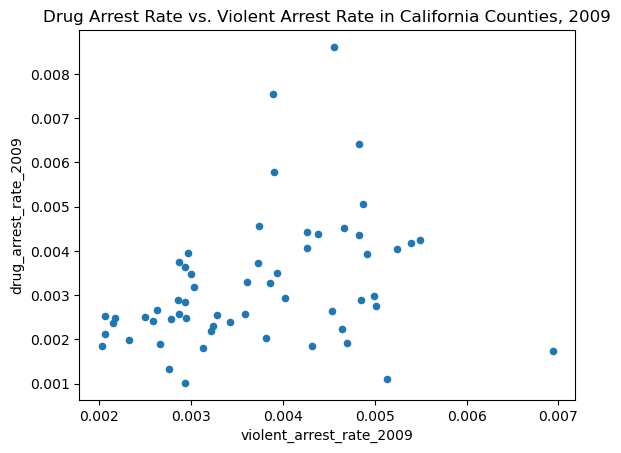

In [38]:
# Subset dataset for required variables
ca_arrests_pop_2009.plot(
    x="violent_arrest_rate_2009", y="drug_arrest_rate_2009", kind="scatter"
)
plt.title("Drug Arrest Rate vs. Violent Arrest Rate in California Counties, 2009")

### Exercise 14

Based on this simple comparison of 2009 violent arrest rates and drug arrest rates, what might you conclude about the relationship between the illegal drug trade and violent crime?

In [39]:
print(
    "The correlation between drug and violent arrest rates is {}.".format(
        ca_arrests_pop_2009["violent_arrest_rate_2009"]
        .corr(ca_arrests_pop_2009["drug_arrest_rate_2009"])
        .round(4)
    )
)
print("This suggest a moderately positive relationship between the two variables.")

The correlation between drug and violent arrest rates is 0.3255.
This suggest a moderately positive relationship between the two variables.


## Comparing with 2018 Arrests

The preceding analysis can tell us about whether violent crime and the drug trade are correlated, but it doesn't tell us much about whether they are *causally* related. It *could* be the case that people dealing drugs *cause* more violent crime, but it could also be that certain communities, for some other reason, tend to have *both* more drug sales *and* more violent crime. 

To help answer this question, let's examine whether violent crime arrest rates changed in response to drug legalization. In particular, let's do this by comparing violent crime arrest rates in 2009 (before drug legalization) to violent crime arrest rates in 2018 (after drug legalization). If the illegal drug trade causes violent crime, then we would expect the violent crime rate to fall in response to drug legalization.


### Exercise 15

Just as we created violent arrest rates and drug arrest rates for 2009, now we want to do it for 2018. Using the data on 2018 arrests (also in the [same repository](https://github.com/nickeubank/practicaldatascience/tree/master/Example_Data/ca) we used before) and the same dataset of population data (you'll have to use population from 2013-2017, as 2018 population data has yet to be released), create a dataset of arrest rates. 

As before, *be careful with your merges!!!*

In [40]:
ca_arrests_2018 = pd.read_csv(
    "https://github.com/nickeubank/practicaldatascience/raw/master/Example_Data/ca/ca_arrests_2018.csv"
)
ca_arrests_2018.sample(5)

,Unnamed: 0,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL
40,2244,San Mateo County,1415,874,228,64,910,3491,13494,43
15,2219,Kings County,603,307,86,42,747,1785,5545,88
21,2225,Mariposa County,32,32,14,3,18,99,390,0
48,2252,Sonoma County,1475,806,265,88,902,3536,13153,9
0,2204,Alameda County,4132,3051,1062,173,2619,11037,28305,82


In [41]:
# subset for only populations for 2018
nhgis_county_pop_2018 = nhgis_county_pop[nhgis_county_pop["YEAR"] == "2013-2017"]
nhgis_county_pop_2018.shape

(58, 4)

In [42]:
# subset for only needed columns as ca_county_pop_2018
ca_county_pop_2018 = nhgis_county_pop_2018[["COUNTY", "total_population"]]
ca_county_pop_2018.head()

,COUNTY,total_population
3407,Alameda County,1629615
3408,Alpine County,1203
3409,Amador County,37306
3410,Butte County,225207
3411,Calaveras County,45057


In [43]:
# rename column
ca_county_pop_2018 = ca_county_pop_2018.rename(columns={"COUNTY": "county_name"})
ca_county_pop_2018.head()

,county_name,total_population
3407,Alameda County,1629615
3408,Alpine County,1203
3409,Amador County,37306
3410,Butte County,225207
3411,Calaveras County,45057


In [44]:
# Merge the two datasets using the "COUNTY" column as the key
ca_arrests_pop_2018 = pd.merge(
    ca_arrests_2018,
    ca_county_pop_2018,
    how="outer",
    left_on="COUNTY",
    right_on="county_name",
    validate="one_to_one",
    indicator=True,
)
print("Exactly what we anticipated:")
print(ca_arrests_pop_2018[ca_arrests_pop_2018._merge != "both"].shape)

Exactly what we anticipated:
(0, 13)


In [45]:
# create a variables that calculates the arrest rates for each county
ca_arrests_pop_2018["violent_arrest_rate_2018"] = (
    ca_arrests_pop_2018["VIOLENT"] / ca_arrests_pop_2018["total_population"]
)
ca_arrests_pop_2018["drug_arrest_rate_2018"] = (
    ca_arrests_pop_2018["F_DRUGOFF"] / ca_arrests_pop_2018["total_population"]
)
ca_arrests_pop_2018.head()

,Unnamed: 0,COUNTY,VIOLENT,PROPERTY,F_DRUGOFF,F_SEXOFF,F_ALLOTHER,F_TOTAL,M_TOTAL,S_TOTAL,county_name,total_population,_merge,violent_arrest_rate_2018,drug_arrest_rate_2018
0,2204,Alameda County,4132,3051,1062,173,2619,11037,28305,82,Alameda County,1629615,both,0.002536,0.000652
1,2205,Alpine County,5,2,1,0,3,11,41,0,Alpine County,1203,both,0.004156,0.000831
2,2206,Amador County,72,40,31,3,142,288,701,1,Amador County,37306,both,0.001930,0.000831
3,2207,Butte County,785,437,229,47,741,2239,8853,1,Butte County,225207,both,0.003486,0.001017
4,2208,Calaveras County,147,42,29,6,96,320,897,0,Calaveras County,45057,both,0.003263,0.000644


### Exercise 16

Now merge our two county-level datasets so you have one row for every county, and variables for violent arrest rates in 2018, violent arrest rates in 2009, felony drug arrest rates in 2018, and felony drug arrest rates in 2009. Store the number of observations in your final data set in your `results` dictionary under the key `"ex16_num_obs"`.

In [46]:
# Merge all county-level datasets
merged_arrest_rate = pd.merge(
    ca_arrests_pop_2018,
    ca_arrests_pop_2009,
    how="outer",
    on="COUNTY",
)
merged_arrest_rate.shape

(58, 28)

In [47]:
merged_arrest_rate = merged_arrest_rate[
    [
        "COUNTY",
        "violent_arrest_rate_2009",
        "violent_arrest_rate_2018",
        "drug_arrest_rate_2009",
        "drug_arrest_rate_2018",
    ]
]
merged_arrest_rate.head()
results["ex16_num_obs"] = merged_arrest_rate.shape[0]

### Exercise 17

Did drug arrests go down from 2009 to 2018 in response to drug legalization? (they sure better! This is what's called a "sanity check" of your data and analysis. If you find drug arrests went *up*, you know something went wrong with your code or your understanding of the situations). 

Store the average county-level change in drug arrests per capita in `results` under the key `"ex17_drug_change"`.

In [48]:
results["ex17_drug_change"] = (
    merged_arrest_rate.drug_arrest_rate_2018.mean()
    - merged_arrest_rate.drug_arrest_rate_2009.mean()
)
print(
    "The average change in drug arrest rate between 2009 and 2018 is {}.".format(
        results["ex17_drug_change"].round(4)
    )
)

The average change in drug arrest rate between 2009 and 2018 is -0.0022.


### Exercise 18

Now we want to look at whether violent crime decreased following drug legalization. Did the average violent arrest rate decrease? By how much? (Note: We're assuming that arrest rates are proportionate to crime rates. If policing increased so that there were more arrests per crime committed, that would impact our interpretation of these results. But this is just an exercise, so...)

Store the average county-level change in violent arrests per capita in `results` under the key `"ex18_violent_change"`

In [49]:
results["ex18_violent_change"] = (
    merged_arrest_rate.violent_arrest_rate_2018.mean()
    - merged_arrest_rate.violent_arrest_rate_2009.mean()
)
print(
    "The average change in violent arrest rate between 2009 and 2018 is {}.".format(
        results["ex18_violent_change"].round(4)
    )
)

The average change in violent arrest rate between 2009 and 2018 is -0.0003.


### Exercise 19

Based on your answers to exercises 17 and 18, what might you conclude about the relationship between the illegal drug trade and violent crime? Did legalizing drugs increase violent crime (assuming arrest rates are a good proxy for crime rates)? Decrease violent crime? Have no effect? 

In [50]:
print(
    f"The answers above has shown that both the violent and drug arrest rates have decreased between 2009 and 2018."
    + f"This indicates that legalizing drugs the state of California resulted in violent crime decrease within the period of study."
)

The answers above has shown that both the violent and drug arrest rates have decreased between 2009 and 2018.This indicates that legalizing drugs the state of California resulted in violent crime decrease within the period of study.


## Difference in Difference Analysis

The preceding analysis is something we sometimes call a "pre-post" analysis, in that it is a comparison of how and outcome we care about (violent arrest rates) changes from before a treatment is introduced ("pre") to after ("post"). BUT: pre-post comparisons are imperfect. If we knew that violent crime was not going to change at all in a world without drug legalization, then this comparison is perfectly valid. But what if, absent drug legalization, violent crime would have fallen on its own (maybe because of advances in policing practices or a better economy)? Or maybe it would have increased?

This is actually a very common problem. For example, imagine you're trying to figure out whether taking tylenol helps with headaches. You have a patient with a headache, you give them tylenol, and then the next day you ask them if they still have a headache, and find out that they don't — does that mean that tylenol cured the headache? Maybe... but most headaches eventually resolve on their own, so maybe the headache would have passed with or without the patient taking tylenol! In fact, there's a term for this phenomenon in medicine — the "natural history" of a disease, which is the trajectory that we think a disease might follow absent treatment. And the natural history of the disease is almost never for it to stay exactly the same indefinitely.

(All of this is closely related to the discipline of causal inference, and if it makes your head to hurt, don't worry — that means you're doing it right! We will talk lots and lots more about it in the weeks and months to come.)

One way to try to overcome this problem is with something called a difference-in-difference analysis. Rather than just looking at whether violent drug arrest rates increase or decrease between 2009 and 2018, we can split our sample of counties into those that were *more* impacted by drug legalization and those that were *less* impacted by drug legalization and evaluate whether we see a greater change in the violent drug arrest rate in the counties that were more impacted. 

What does it mean to have been "more impacted" by drug legalization? In this case, we can treat the counties that had higher drug arrest rates in 2009 as counties that were more impacted by drug legalization than those that had low drug arrest rates in 2009. After all, in a county that had no drug arrests, legalization wouldn't do anything, would it? 



### Exercise 20

First, split our sample into two groups: high drug arrests in 2009, and low drug arrests in 2009 (cut the sample at the average drug arrest rate in 2009). 


In [51]:
high_drug_arrest = merged_arrest_rate.loc[
    merged_arrest_rate["drug_arrest_rate_2009"]
    > merged_arrest_rate["drug_arrest_rate_2009"].mean()
]
low_drug_arrest = merged_arrest_rate.loc[
    merged_arrest_rate["drug_arrest_rate_2009"]
    < merged_arrest_rate["drug_arrest_rate_2009"].mean()
]
high_drug_arrest.head()

,COUNTY,violent_arrest_rate_2009,violent_arrest_rate_2018,drug_arrest_rate_2009,drug_arrest_rate_2018
0,Alameda County,0.002963,0.002536,0.003946,0.000652
9,Fresno County,0.004914,0.004442,0.003938,0.000571
10,Glenn County,0.003729,0.003580,0.003729,0.000823
11,Humboldt County,0.003899,0.003631,0.005791,0.000989
12,Imperial County,0.003743,0.002228,0.004562,0.000806



### Exercise 21

Now, determine weather violent crime changed *more* from 2009 to 2018 in the counties that had lots of drug arrests in 2009 (where legalization likely had more of an effect) than in counties with fewer drug arrests in 2009 (where legalization likely mattered less)? 

Calculate this difference-in-difference:

```
(the change in violent crime rate per capita for counties with lots of drug arrests in 2009) 
- (the change in violent crime rate per capita for counties with few drug arrests in 2009)

```

Store your "difference-in-difference" estimate in your `results` dictionary under the key `"ex21_diffindiff"`.

In [52]:
c_high = (
    high_drug_arrest.violent_arrest_rate_2018.mean()
    - high_drug_arrest.violent_arrest_rate_2009.mean()
)

c_low = (
    low_drug_arrest.violent_arrest_rate_2018.mean()
    - low_drug_arrest.violent_arrest_rate_2009.mean()
)

results["ex21_diffindiff"] = c_high - c_low
print(
    "The difference-in-difference estimate is: {}".format(
        results["ex21_diffindiff"].round(5)
    )
)

The difference-in-difference estimate is: -0.00025


### Exercise 22

Interpret your difference in difference result.

### Exercise 23

The quantity we estimated above is a little difficult to interpret. Rather than calculating the *absolute* change in violent arrest rates per capita, let's calculate the *proportionate* change.

Calculate:

```
(the county-level percentage change in violent crime rate with lots of drug arrests in 2009) 
- (the county-level percentage change in violent crime rate with few drug arrests in 2009)
```
Store your "difference-in-difference" estimate in your `results` dictionary under the key `"ex24_diffindiff_proportionate"`. Report your result in percentages, such that a value of `-100` would imply that the average county experienced a 100% decrease in the violent arrest rate.

In [53]:
diffindiff_proportionate = c_high - c_low

ex23_diffindiff_proportionate = diffindiff_proportionate.mean()

results["ex23_diffindiff_proportionate"] = ex23_diffindiff_proportionate

print(
    "A propotionate change of {} prepresents a 100% decrease in violent arrest rate for an average county in California.".format(
        results["ex23_diffindiff_proportionate"]
    )
)

A propotionate change of -0.00024739378861355797 prepresents a 100% decrease in violent arrest rate for an average county in California.


In [54]:
assert set(results.keys()) == {
    "ex6_validate_keyword",
    "ex10_merged_successfully",
    "ex16_num_obs",
    "ex17_drug_change",
    "ex18_violent_change",
    "ex21_diffindiff",
    "ex23_diffindiff_proportionate",
}